In [1]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries.
# ---------------------------------------------------------------------------
from pathlib import Path
import geopandas as gpd

# Load your vector file
vector_path = Path("C:/Users/gades/Documents/2013-2023_fires.shp")  # Use your actual file path
gdf = gpd.read_file(vector_path)

# Reproject to a projected CRS for area calculation
gdf_proj = gdf.to_crs(epsg=3857)

# Estimate pixel size and minimum area (based on 0.05 degrees)
pixel_size_deg = 0.05
pixel_size_m = 111320 * pixel_size_deg  # approx. at equator
min_area = pixel_size_m ** 2

# Filter polygons
gdf_filtered = gdf_proj[gdf_proj.geometry.area >= min_area]

# Reproject back to original CRS
gdf_filtered = gdf_filtered.to_crs(gdf.crs)

# Create output path: adds "_filtered" to original filename
output_path = vector_path.with_name(vector_path.stem + "_filtered" + vector_path.suffix)

# Save filtered file
gdf_filtered.to_file(output_path)

print(f"Filtered file saved as: {output_path}")


Filtered file saved as: C:\Users\gades\Documents\2013-2023_fires_filtered.shp


C:\Users\gades\AppData\Roaming\Python\Python39\site-packages\pyogrio\raw.py:709: RuntimeWarning: Field StartDate_ create as date field, though DateTime requested.
  ogr_write(


In [ ]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: Explanation forthcoming – general processing step in FFDI validation workflow.
# ---------------------------------------------------------------------------


In [5]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries and reads one or more raster files for analysis.
# ---------------------------------------------------------------------------
import geopandas as gpd
import rasterio
from rasterio.plot import show
from pathlib import Path
import os

# --- Paths ---
input_folder = Path("C:/Users/gades/Desktop/Thesis/datasets/terra_var/FFDI_finaldf90_reprojected")  # folder with 132 FFDI rasters
vector_path = Path("C:/Users/gades/Documents/2013-2023_fires_filtered.shp")

# --- Load fire polygon vector ---
gdf = gpd.read_file(vector_path)

# Check CRS
vector_crs = gdf.crs
print(f"Vector CRS: {vector_crs}")

# --- Loop through raster files ---
for raster_file in sorted(input_folder.glob("*.tif")):
    with rasterio.open(raster_file) as src:
        raster_crs = src.crs
        raster_bounds = src.bounds

        # 1. Check CRS
        if raster_crs != vector_crs:
            print(f"[CRS MISMATCH] {raster_file.name}")
        else:
            print(f"[✓ CRS MATCH] {raster_file.name}")

        # 2. Check spatial overlap
        vector_bounds = gdf.total_bounds  # (minx, miny, maxx, maxy)

        def overlaps(bounds1, bounds2):
            # Check if bounding boxes intersect
            return not (
                bounds1[2] < bounds2[0] or  # right < left
                bounds1[0] > bounds2[2] or  # left > right
                bounds1[3] < bounds2[1] or  # top < bottom
                bounds1[1] > bounds2[3]     # bottom > top
            )

        if overlaps(raster_bounds, vector_bounds):
            print(f"    [✓ OVERLAPS]")
        else:
            print(f"    [X NO OVERLAP]")

print("Check complete.")


Vector CRS: EPSG:4283
[✓ CRS MATCH] ffdi_2013-01.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-02.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-03.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-04.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-05.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-06.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-07.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-08.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-09.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-10.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-11.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2013-12.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2014-01.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2014-02.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2014-03.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2014-04.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2014-05.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2014-06.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2014-07.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi_2014-08.tif
    [✓ OVERLAPS]
[✓ CRS MATCH] ffdi

In [7]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: Explanation forthcoming – general processing step in FFDI validation workflow.
# ---------------------------------------------------------------------------
pip install rasterstats


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for rasterstats from https://files.pythonhosted.org/packages/5e/0b/bd73621d2a5f87da97158c5c77a4bf31e27d60cf6bcc6ddea532043cc21d/rasterstats-0.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for simplejson from https://files.pythonhosted.org/packages/88/c9/d8bf87aaebec5a4c3ccfd5228689578e2fe77027d6114a259255d54969bf/simplejson-3.20.1-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 75.7/75.7 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<Figure size 1800x800 with 0 Axes>

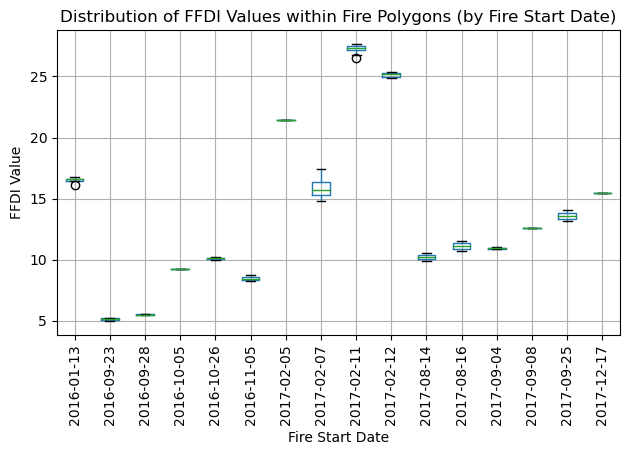

In [8]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries and reads one or more raster files for analysis.
# ---------------------------------------------------------------------------
import geopandas as gpd
import pandas as pd
import rasterio
import rasterio.mask
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Paths
vector_path = "C:/Users/gades/Documents/2013-2023_fires_filtered.shp"
raster_folder = Path("C:/Users/gades/Desktop/Thesis/datasets/terra_var/FFDI_finaldf90_reprojected")

# Load polygons
gdf = gpd.read_file(vector_path)

# Correct fire date extraction
gdf['fire_date'] = pd.to_datetime(gdf['StartDate'])

# Filter to 2013-2014 fires
gdf = gdf[(gdf['fire_date'].dt.year >= 2016) & (gdf['fire_date'].dt.year <= 2017)]

# Collect pixel-level FFDI values
all_ffdi_values = []

for idx, row in gdf.iterrows():
    fire_date = row['fire_date']
    polygon = row['geometry']
    poly_id = idx

    raster_name = f"FFDI_{fire_date.year}-{fire_date.month:02d}.tif"
    raster_path = raster_folder / raster_name

    if raster_path.exists():
        with rasterio.open(raster_path) as src:
            try:
                out_image, out_transform = rasterio.mask.mask(src, [polygon], crop=True)
                out_image = out_image[0]  # First band

                # Mask no data values
                valid_pixels = out_image[out_image != src.nodata]

                # Further remove any NaNs if they exist
                valid_pixels = valid_pixels[~np.isnan(valid_pixels)]

                for value in valid_pixels:
                    all_ffdi_values.append({
                        "polygon_id": poly_id,
                        "fire_date": fire_date,
                        "ffdi_value": value
                    })

            except ValueError:
                print(f"No valid pixels for polygon {poly_id} at {fire_date}")

    else:
        print(f"Raster not found for {fire_date}: {raster_name}")

# Create dataframe
df_values = pd.DataFrame(all_ffdi_values)

plt.figure(figsize=(18, 8))

# Format StartDate nicely as string
df_values['fire_date_str'] = df_values['fire_date'].dt.strftime('%Y-%m-%d')

# Boxplot grouped by individual fire StartDate
df_values.boxplot(column='ffdi_value', by='fire_date_str', grid=True, showfliers=True)

plt.title('Distribution of FFDI Values within Fire Polygons (by Fire Start Date)')
plt.suptitle('')  # remove default automatic title
plt.xlabel('Fire Start Date')
plt.ylabel('FFDI Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [15]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: Explanation forthcoming – general processing step in FFDI validation workflow.
# ---------------------------------------------------------------------------
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable


📭 No fires in 2013-01
📭 No fires in 2013-02
📭 No fires in 2013-03
📭 No fires in 2013-04
📭 No fires in 2013-05
📭 No fires in 2013-06
📭 No fires in 2013-07

📅 Processing ffdi_2013-08.tif — 1 fire(s)
✅ Fire pixels: 5, Non-fire pixels sampled: 5

📅 Processing ffdi_2013-09.tif — 2 fire(s)
✅ Fire pixels: 15, Non-fire pixels sampled: 14

📅 Processing ffdi_2013-10.tif — 16 fire(s)
✅ Fire pixels: 226, Non-fire pixels sampled: 190
📭 No fires in 2013-11

📅 Processing ffdi_2013-12.tif — 1 fire(s)
✅ Fire pixels: 30, Non-fire pixels sampled: 30

📅 Processing ffdi_2014-01.tif — 3 fire(s)
✅ Fire pixels: 32, Non-fire pixels sampled: 17
📭 No fires in 2014-02
📭 No fires in 2014-03
📭 No fires in 2014-04
📭 No fires in 2014-05
📭 No fires in 2014-06
📭 No fires in 2014-07

📅 Processing ffdi_2014-08.tif — 1 fire(s)
✅ Fire pixels: 5, Non-fire pixels sampled: 5
📭 No fires in 2014-09

📅 Processing ffdi_2014-10.tif — 4 fire(s)
✅ Fire pixels: 35, Non-fire pixels sampled: 35

📅 Processing ffdi_2014-11.tif — 2 fire(s

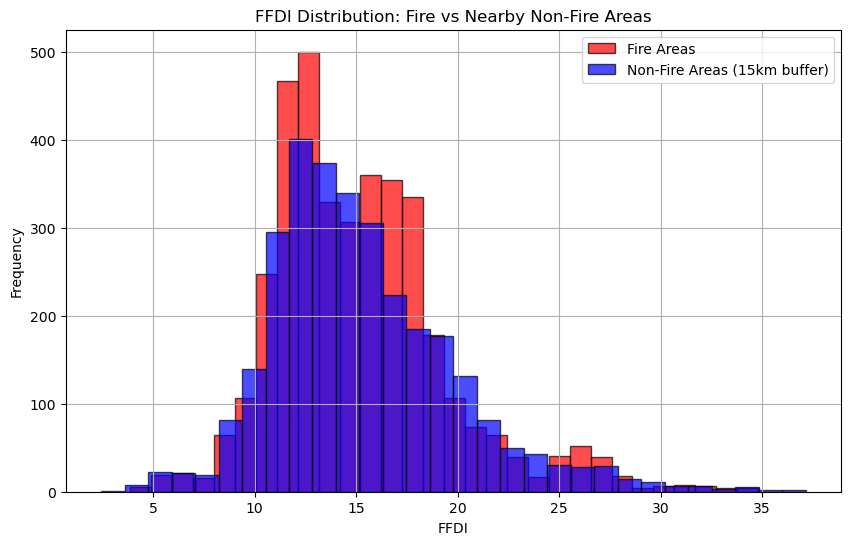

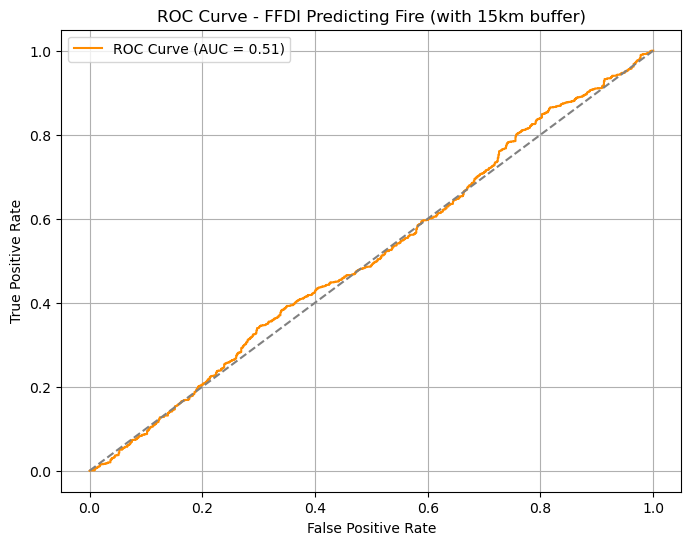

In [16]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries and reads one or more raster files for analysis and creates visualizations or plots.
# ---------------------------------------------------------------------------
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, Point, box
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

# === 1. PATHS ===
fire_shapefile =  "C:/Users/gades/Desktop/Thesis/results/fires_filtered_nz.shp"
ffdi_folder = Path("C:/Users/gades/Desktop/Thesis/datasets/terra_var/FFDI_finaldf90")

# === 2. LOAD FIRE POLYGONS ===
fire_gdf = gpd.read_file(fire_shapefile)
fire_gdf['fire_date'] = pd.to_datetime(fire_gdf['StartDate'])
fire_gdf['year_month'] = fire_gdf['fire_date'].dt.strftime('%Y-%m')

# === 3. SETUP HOLDERS ===
fire_ffdi_vals = []
nonfire_ffdi_vals = []

# === 4. LOOP MONTH BY MONTH ===
for raster_file in sorted(ffdi_folder.glob("FFDI_*.tif")):
    raster_ym = raster_file.stem.split("_")[1]

    fires_this_month = fire_gdf[fire_gdf['year_month'] == raster_ym]
    if fires_this_month.empty:
        print(f"📭 No fires in {raster_ym}")
        continue

    with rasterio.open(raster_file) as src:
        raster_crs = src.crs
        fires_this_month = fires_this_month.to_crs(raster_crs)

        print(f"\n📅 Processing {raster_file.name} — {len(fires_this_month)} fire(s)")

        # === 4A. Extract FFDI for fire polygons AND count pixels ===
        fire_pixel_count = 0

        for idx, row in fires_this_month.iterrows():
            try:
                out_image, _ = mask(src, [mapping(row.geometry)], crop=True, all_touched=True, nodata=src.nodata)
                data = out_image[0]
                valid = data[(data != src.nodata) & (~np.isnan(data))]
                fire_ffdi_vals.extend(valid.tolist())
                fire_pixel_count += len(valid)  # Count fire pixels
            except Exception as e:
                print(f"⚠️ Skipped fire ID {idx}: {e}")

        if fire_pixel_count == 0:
            print("⚠️ No valid fire pixels found for this month. Skipping.")
            continue

        # === 4B. Create 20 km buffer properly using UTM ===
        utm_crs = fires_this_month.estimate_utm_crs()
        fires_utm = fires_this_month.to_crs(utm_crs)
        buffered_fire = fires_utm.buffer(15000)  # 20,000 meters = 20 km

        buffered_fire_gdf = gpd.GeoSeries(buffered_fire, crs=utm_crs).to_crs(raster_crs)

        buffer_area = buffered_fire_gdf.union_all().difference(fires_this_month.geometry.union_all())

        raster_bounds_geom = box(*src.bounds)
        buffer_clipped = buffer_area.intersection(raster_bounds_geom)

        if buffer_clipped.is_empty:
            print("⚠️ Skipping: Buffer outside raster bounds.")
            continue

        # === 4C. Generate exactly 'fire_pixel_count' random points inside buffer ===
        def get_random_points_within(geom, n):
            minx, miny, maxx, maxy = geom.bounds
            points = []
            tries = 0
            max_tries = n * 10
            while len(points) < n and tries < max_tries:
                p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
                if geom.contains(p):
                    points.append(p)
                tries += 1
            return points

        bg_points = get_random_points_within(buffer_clipped, n=fire_pixel_count)

        print(f"✅ Fire pixels: {fire_pixel_count}, Non-fire pixels sampled: {len(bg_points)}")

        # === 4D. Extract FFDI at random points
        for pt in bg_points:
            row, col = src.index(pt.x, pt.y)
            try:
                val = src.read(1)[row, col]
                if val != src.nodata and not np.isnan(val):
                    nonfire_ffdi_vals.append(val)
            except:
                continue

print("\n✅ Data collection complete.")

# =========================
# ANALYSIS: KS Test + Logistic Regression
# =========================

# --- Merge into DataFrame ---
fire_df = pd.DataFrame({'FFDI': fire_ffdi_vals, 'fire': 1})
nonfire_df = pd.DataFrame({'FFDI': nonfire_ffdi_vals, 'fire': 0})
df = pd.concat([fire_df, nonfire_df], ignore_index=True)

print("\nDataset Summary:")
print(df['fire'].value_counts())

# --- KS Test ---
print("\n--- KS Test ---")
ks_stat, ks_p = ks_2samp(fire_ffdi_vals, nonfire_ffdi_vals)
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-Value: {ks_p:.4e}")

# --- Logistic Regression ---
print("\n--- Logistic Regression ---")
X = df[['FFDI']].values
y = df['fire'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print(f"Model: logit(p) = {logreg.intercept_[0]:.4f} + {logreg.coef_[0][0]:.4f} * FFDI")

# --- Predictions ---
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc:.4f}")

# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_test, logreg.predict(X_test))
print("Confusion Matrix:")
print(conf_mat)

# =========================
# PLOTS
# =========================

# --- Histograms ---
plt.figure(figsize=(10, 6))
plt.hist(fire_ffdi_vals, bins=30, alpha=0.7, label="Fire Areas", color="red", edgecolor="black")
plt.hist(nonfire_ffdi_vals, bins=30, alpha=0.7, label="Non-Fire Areas (15km buffer)", color="blue", edgecolor="black")
plt.xlabel("FFDI")
plt.ylabel("Frequency")
plt.title("FFDI Distribution: Fire vs Nearby Non-Fire Areas")
plt.legend()
plt.grid(True)
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle='--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - FFDI Predicting Fire (with 15km buffer)")
plt.legend()
plt.grid(True)
plt.show()



📭 No fires in 2013-01
📭 No fires in 2013-02
📭 No fires in 2013-03
📭 No fires in 2013-04
📭 No fires in 2013-05
📭 No fires in 2013-06
📭 No fires in 2013-07

📅 Processing ffdi_2013-08.tif — 1 fire(s)
✅ Fire pixels: 5, Non-fire pixels sampled: 5

📅 Processing ffdi_2013-09.tif — 2 fire(s)
✅ Fire pixels: 15, Non-fire pixels sampled: 15

📅 Processing ffdi_2013-10.tif — 16 fire(s)
✅ Fire pixels: 226, Non-fire pixels sampled: 184
📭 No fires in 2013-11

📅 Processing ffdi_2013-12.tif — 1 fire(s)
✅ Fire pixels: 30, Non-fire pixels sampled: 30

📅 Processing ffdi_2014-01.tif — 3 fire(s)
✅ Fire pixels: 32, Non-fire pixels sampled: 15
📭 No fires in 2014-02
📭 No fires in 2014-03
📭 No fires in 2014-04
📭 No fires in 2014-05
📭 No fires in 2014-06
📭 No fires in 2014-07

📅 Processing ffdi_2014-08.tif — 1 fire(s)
✅ Fire pixels: 5, Non-fire pixels sampled: 5
📭 No fires in 2014-09

📅 Processing ffdi_2014-10.tif — 4 fire(s)
✅ Fire pixels: 35, Non-fire pixels sampled: 35

📅 Processing ffdi_2014-11.tif — 2 fire(s

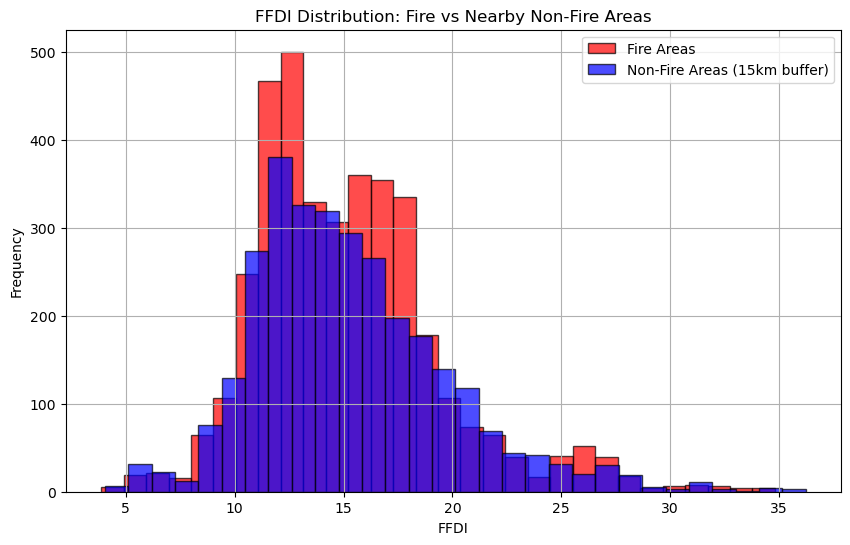

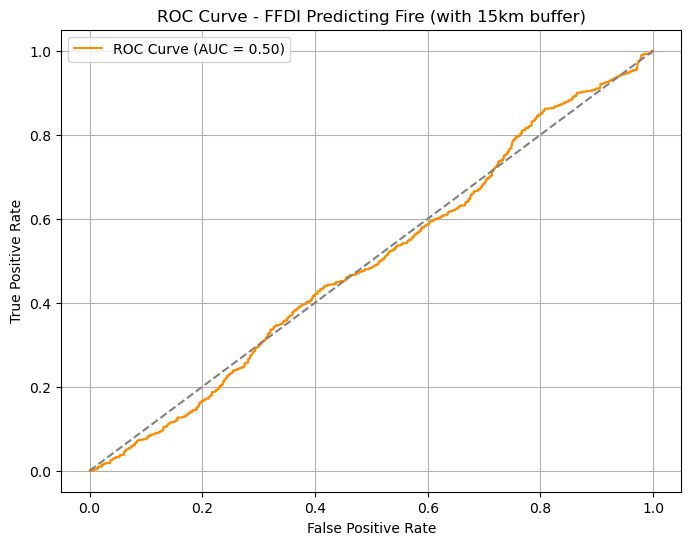

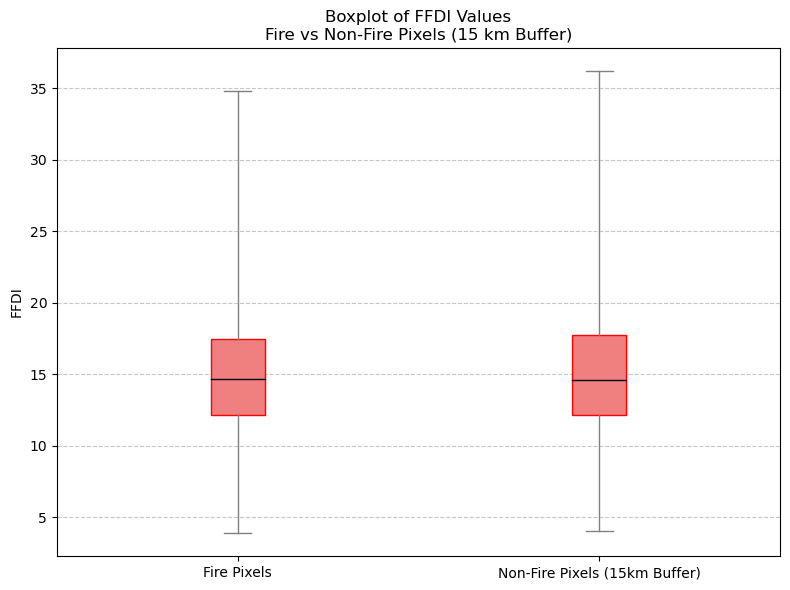

In [17]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries and reads one or more raster files for analysis and creates visualizations or plots.
# ---------------------------------------------------------------------------
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, Point, box
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

# === 1. PATHS ===
fire_shapefile =  "C:/Users/gades/Desktop/Thesis/results/fires_filtered_nz.shp"
ffdi_folder = Path("C:/Users/gades/Desktop/Thesis/datasets/terra_var/FFDI_finaldf90")

# === 2. LOAD FIRE POLYGONS ===
fire_gdf = gpd.read_file(fire_shapefile)
fire_gdf['fire_date'] = pd.to_datetime(fire_gdf['StartDate'])
fire_gdf['year_month'] = fire_gdf['fire_date'].dt.strftime('%Y-%m')

# === 3. SETUP HOLDERS ===
fire_ffdi_vals = []
nonfire_ffdi_vals = []

# === 4. LOOP MONTH BY MONTH ===
for raster_file in sorted(ffdi_folder.glob("FFDI_*.tif")):
    raster_ym = raster_file.stem.split("_")[1]

    fires_this_month = fire_gdf[fire_gdf['year_month'] == raster_ym]
    if fires_this_month.empty:
        print(f"📭 No fires in {raster_ym}")
        continue

    with rasterio.open(raster_file) as src:
        raster_crs = src.crs
        fires_this_month = fires_this_month.to_crs(raster_crs)

        print(f"\n📅 Processing {raster_file.name} — {len(fires_this_month)} fire(s)")

        # === 4A. Extract FFDI for fire polygons AND count pixels ===
        fire_pixel_count = 0

        for idx, row in fires_this_month.iterrows():
            try:
                out_image, _ = mask(src, [mapping(row.geometry)], crop=True, all_touched=True, nodata=src.nodata)
                data = out_image[0]
                valid = data[(data != src.nodata) & (~np.isnan(data))]
                fire_ffdi_vals.extend(valid.tolist())
                fire_pixel_count += len(valid)  # Count fire pixels
            except Exception as e:
                print(f"⚠️ Skipped fire ID {idx}: {e}")

        if fire_pixel_count == 0:
            print("⚠️ No valid fire pixels found for this month. Skipping.")
            continue

        # === 4B. Create 20 km buffer properly using UTM ===
        utm_crs = fires_this_month.estimate_utm_crs()
        fires_utm = fires_this_month.to_crs(utm_crs)
        buffered_fire = fires_utm.buffer(15000)  # 20,000 meters = 20 km

        buffered_fire_gdf = gpd.GeoSeries(buffered_fire, crs=utm_crs).to_crs(raster_crs)

        buffer_area = buffered_fire_gdf.union_all().difference(fires_this_month.geometry.union_all())

        raster_bounds_geom = box(*src.bounds)
        buffer_clipped = buffer_area.intersection(raster_bounds_geom)

        if buffer_clipped.is_empty:
            print("⚠️ Skipping: Buffer outside raster bounds.")
            continue

        # === 4C. Generate exactly 'fire_pixel_count' random points inside buffer ===
        def get_random_points_within(geom, n):
            minx, miny, maxx, maxy = geom.bounds
            points = []
            tries = 0
            max_tries = n * 10
            while len(points) < n and tries < max_tries:
                p = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
                if geom.contains(p):
                    points.append(p)
                tries += 1
            return points

        bg_points = get_random_points_within(buffer_clipped, n=fire_pixel_count)

        print(f"✅ Fire pixels: {fire_pixel_count}, Non-fire pixels sampled: {len(bg_points)}")

        # === 4D. Extract FFDI at random points
        for pt in bg_points:
            row, col = src.index(pt.x, pt.y)
            try:
                val = src.read(1)[row, col]
                if val != src.nodata and not np.isnan(val):
                    nonfire_ffdi_vals.append(val)
            except:
                continue

print("\n✅ Data collection complete.")

# =========================
# ANALYSIS: KS Test + Logistic Regression
# =========================

# --- Merge into DataFrame ---
fire_df = pd.DataFrame({'FFDI': fire_ffdi_vals, 'fire': 1})
nonfire_df = pd.DataFrame({'FFDI': nonfire_ffdi_vals, 'fire': 0})
df = pd.concat([fire_df, nonfire_df], ignore_index=True)

print("\nDataset Summary:")
print(df['fire'].value_counts())

# --- KS Test ---
print("\n--- KS Test ---")
ks_stat, ks_p = ks_2samp(fire_ffdi_vals, nonfire_ffdi_vals)
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-Value: {ks_p:.4e}")

# --- Logistic Regression ---
print("\n--- Logistic Regression ---")
X = df[['FFDI']].values
y = df['fire'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print(f"Model: logit(p) = {logreg.intercept_[0]:.4f} + {logreg.coef_[0][0]:.4f} * FFDI")

# --- Predictions ---
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc:.4f}")

# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_test, logreg.predict(X_test))
print("Confusion Matrix:")
print(conf_mat)

# =========================
# PLOTS
# =========================

# --- Histograms ---
plt.figure(figsize=(10, 6))
plt.hist(fire_ffdi_vals, bins=30, alpha=0.7, label="Fire Areas", color="red", edgecolor="black")
plt.hist(nonfire_ffdi_vals, bins=30, alpha=0.7, label="Non-Fire Areas (15km buffer)", color="blue", edgecolor="black")
plt.xlabel("FFDI")
plt.ylabel("Frequency")
plt.title("FFDI Distribution: Fire vs Nearby Non-Fire Areas")
plt.legend()
plt.grid(True)
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle='--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - FFDI Predicting Fire (with 15km buffer)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(
    [fire_ffdi_vals, nonfire_ffdi_vals],
    labels=["Fire Pixels", "Non-Fire Pixels (15km Buffer)"],
    patch_artist=True,
    boxprops=dict(facecolor='lightcoral', color='red'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='gray'),
    capprops=dict(color='gray'),
    flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none'),
    showfliers=False,   # <-- Hide outliers
    whis=[0, 100]       # <-- Whiskers extend to min and max
)
plt.ylabel("FFDI")
plt.title("Boxplot of FFDI Values\nFire vs Non-Fire Pixels (15 km Buffer)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("ffdi_boxplot1.png", dpi=300)
plt.show()


In [18]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: Explanation forthcoming – general processing step in FFDI validation workflow.
# ---------------------------------------------------------------------------
!pip install esda libpysal


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for esda from https://files.pythonhosted.org/packages/ea/e1/6000a61d9a964dbb592db8271232693ef2e341d088c7bdf9393a9a34b658/esda-2.5.1-py3-none-any.whl.metadata
  Obtaining dependency information for libpysal from https://files.pythonhosted.org/packages/1e/54/1d6caca55ed3d8d57a544853dd72a0514b464dbd787f28883bec2123ae29/libpysal-4.8.1-py3-none-any.whl.metadata
   -------------------------------------- 132.4/132.4 kB 782.8 kB/s eta 0:00:00
   ---------------------------------------- 2.8/2.8 MB 10.5 MB/s eta 0:00:00


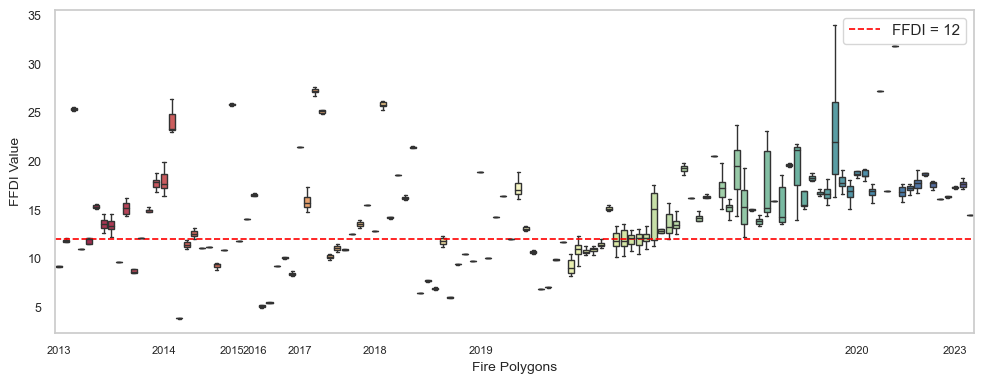

In [1]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries and reads one or more raster files for analysis.
# ---------------------------------------------------------------------------
import geopandas as gpd
import pandas as pd
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set seaborn style
sns.set(style="whitegrid")

# Paths
vector_path = "C:/Users/gades/Desktop/Thesis/results/fires_filtered_nz.shp"
raster_folder = Path("C:/Users/gades/Desktop/Thesis/datasets/terra_var/FFDI_finaldf90_reprojected")

# Load shapefile
gdf = gpd.read_file(vector_path)

# Convert to datetime and extract year
gdf['fire_date'] = pd.to_datetime(gdf['StartDate'])
gdf['fire_year'] = gdf['fire_date'].dt.year
gdf['polygon_id'] = gdf.index.astype(str)

# Extract FFDI values for each polygon
all_ffdi_values = []

for idx, row in gdf.iterrows():
    polygon_id = row['polygon_id']
    fire_year = row['fire_year']
    fire_date = row['fire_date']
    polygon = row['geometry']

    raster_name = f"FFDI_{fire_date.year}-{fire_date.month:02d}.tif"
    raster_path = raster_folder / raster_name

    if raster_path.exists():
        with rasterio.open(raster_path) as src:
            try:
                out_image, _ = rasterio.mask.mask(src, [polygon], crop=True)
                out_image = out_image[0]
                valid_pixels = out_image[out_image != src.nodata]
                valid_pixels = valid_pixels[~np.isnan(valid_pixels)]

                for value in valid_pixels:
                    all_ffdi_values.append({
                        "polygon_id": polygon_id,
                        "fire_year": fire_year,
                        "fire_date": fire_date,
                        "ffdi_value": value
                    })

            except ValueError:
                print(f"Empty pixels for polygon {idx} on {fire_date}")
    else:
        print(f"Missing raster for {fire_date}: {raster_name}")

# Create DataFrame
df = pd.DataFrame(all_ffdi_values)

# Sort by date and assign index
df = df.sort_values("fire_date").reset_index(drop=True)
df["polygon_index"] = df.groupby("fire_date").ngroup()

# Create x-axis labels for first polygon per year
xticks = []
xlabels = []
prev_year = None

unique_dates = df.drop_duplicates("polygon_index")[["polygon_index", "fire_date"]]
for _, row in unique_dates.iterrows():
    year = row["fire_date"].year
    if year != prev_year:
        xticks.append(row["polygon_index"])
        xlabels.append(str(year))
        prev_year = year

# Plot compact boxplot
plt.figure(figsize=(10, 4))  # Compact size for Word
sns.boxplot(
    data=df,
    x="polygon_index",
    y="ffdi_value",
    showfliers=False,
    linewidth=1,
    palette="Spectral"
)

# Add FFDI threshold line
plt.axhline(y=12, color='red', linestyle='--', linewidth=1.2, label='FFDI = 12')
plt.legend()

# Titles and labels
plt.xlabel("Fire Polygons", fontsize=10)
plt.ylabel("FFDI Value", fontsize=10)
plt.xticks(ticks=xticks, labels=xlabels, rotation=0, fontsize=8)
plt.yticks(fontsize=9)
plt.grid(False)
plt.tight_layout()

# Save plot
plt.savefig("C:/Users/gades/Desktop/Thesis/results/boxplot_ffdi_firepolygons99.png", dpi=300, bbox_inches='tight')

# Display plot
plt.show()


Histogram saved to: C:/Users/gades/Desktop/Thesis/results/high_risk_overlap_histogram.png


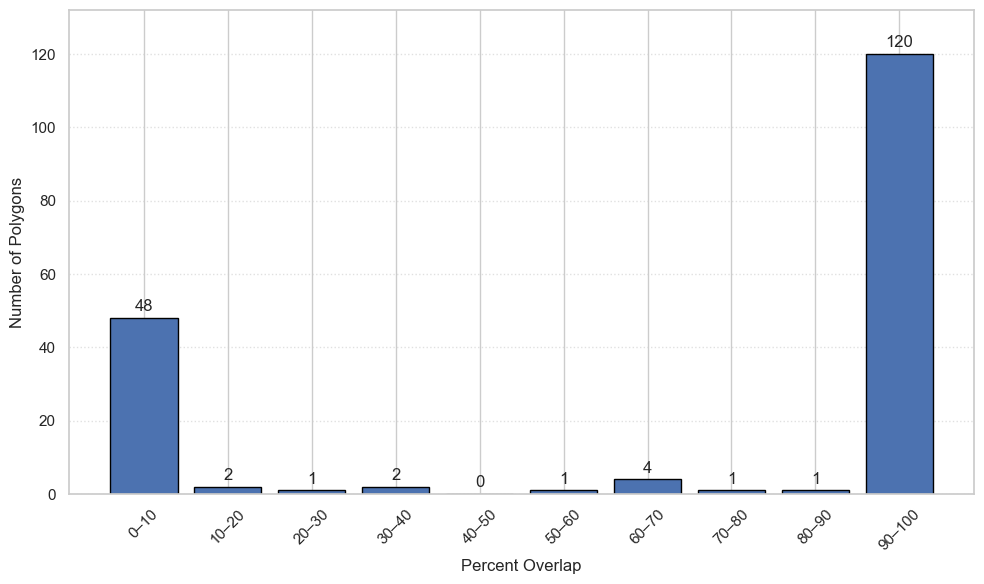

In [22]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries.
# ---------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ─── Load the CSV ─────────────────────────────────────────────────────────────
csv_path = r"C:/Users/gades/Desktop/Thesis/results/overlay.csv"
df = pd.read_csv(csv_path)

# Ensure numeric
df['PercentOverlap'] = pd.to_numeric(df['PercentOverlap'], errors='coerce')
df = df.dropna(subset=['PercentOverlap'])

# ─── Define bins ──────────────────────────────────────────────────────────────
bins   = np.arange(0, 110, 10)   # [  0, 10, 20, ..., 100 ]
labels = [f"{b}–{b+10}" for b in bins[:-1]]

# Use right=True so that 100 falls into the last bin, include_lowest for the 0-edge
df['OverlapBin'] = pd.cut(
    df['PercentOverlap'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# Count polygons per bin
bin_counts = df['OverlapBin'].value_counts().reindex(labels, fill_value=0)

# ─── Plot ────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, bin_counts, color='C0', edgecolor='black')

# Annotate counts on top
for bar in bars:
    y = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        y + 1,
        int(y),
        ha='center', va='bottom'
    )


ax.set_xlabel("Percent Overlap", fontsize=12)
ax.set_ylabel("Number of Polygons", fontsize=12)
ax.set_ylim(0, bin_counts.max() * 1.1)
ax.grid(axis='y', linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# ─── Save Plot ────────────────────────────────────────────────────────────────
save_path = r"C:/Users/gades/Desktop/Thesis/results/high_risk_overlap_histogram.png"
plt.savefig(save_path, dpi=300)
print(f"Histogram saved to: {save_path}")

plt.show()


Plot saved to: C:/Users/gades/Desktop/Thesis/results/monthly_overlap_per_year.png


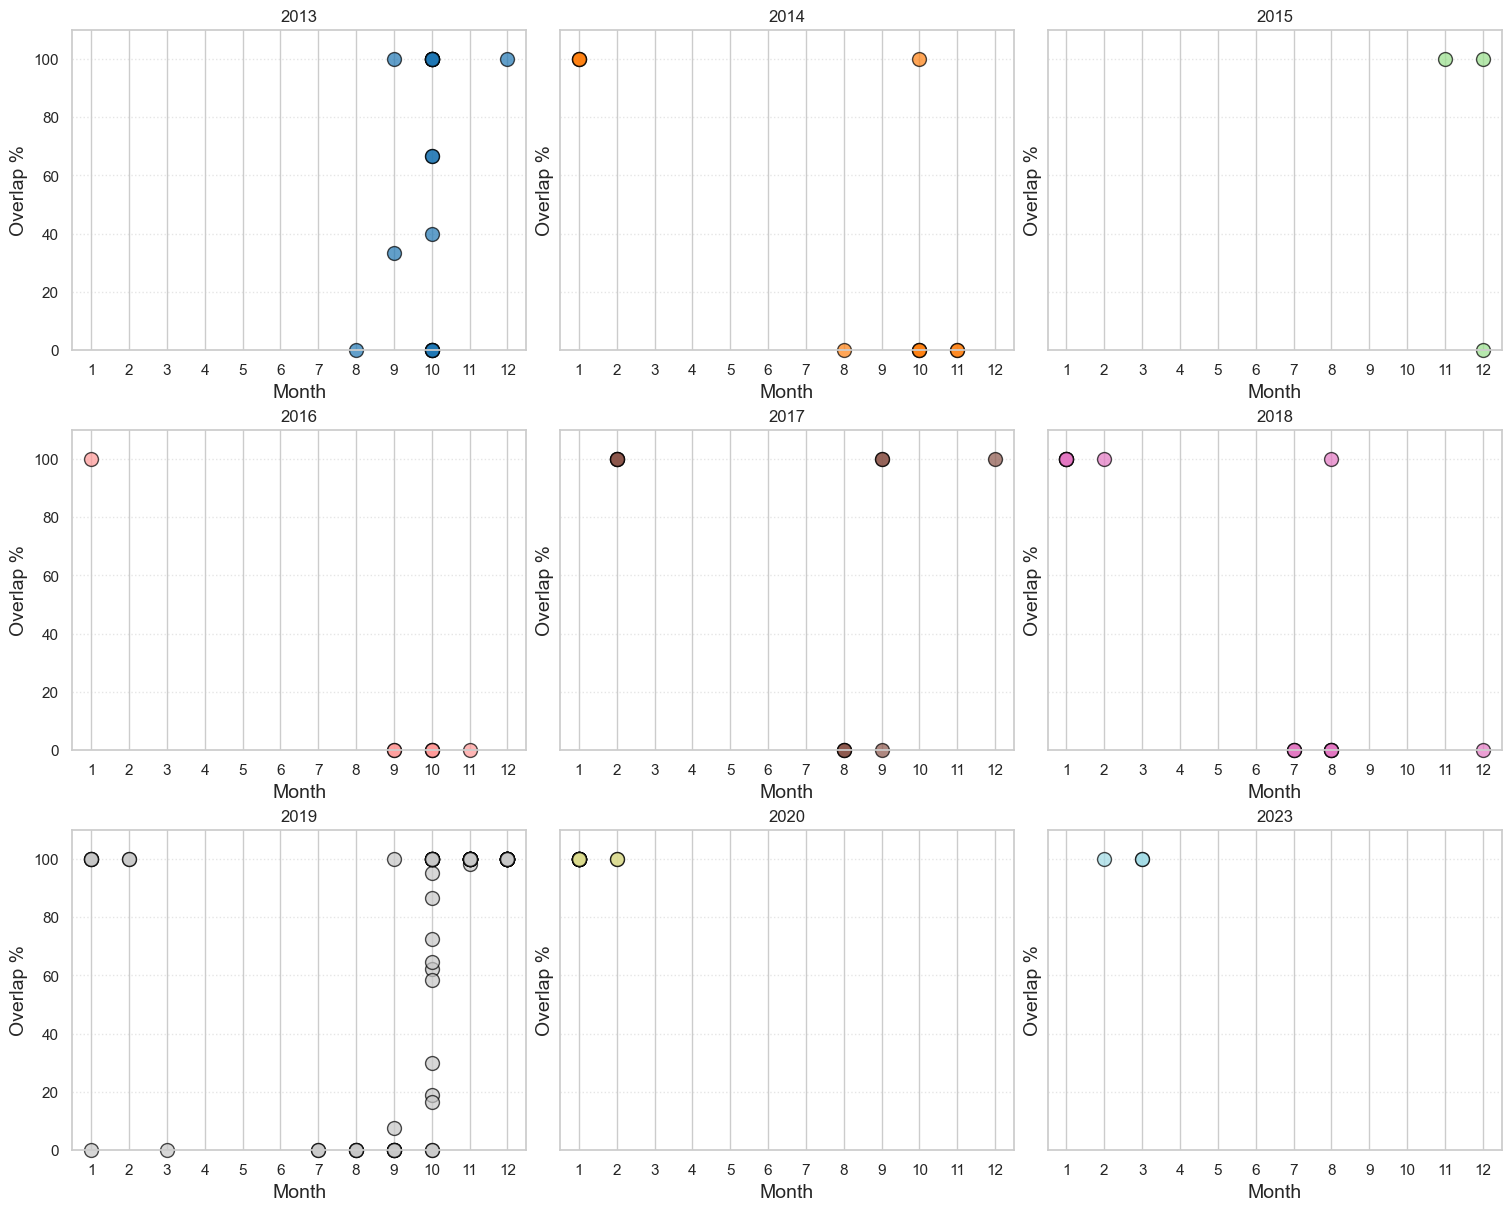

In [53]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries.
# ---------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# ─── Load Data ────────────────────────────────────────────────────────────────
csv_path = r"C:/Users/gades/Desktop/Thesis/results/overlay.csv"
df = pd.read_csv(csv_path)

df['PercentOverlap'] = pd.to_numeric(df['PercentOverlap'], errors='coerce')
df = df.dropna(subset=['PercentOverlap'])

df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['Year'] = df['StartDate'].dt.year
df['Month'] = df['StartDate'].dt.month

# ─── Setup ────────────────────────────────────────────────────────────────────
years = sorted(df['Year'].dropna().unique())
cols = 3
rows = int(np.ceil(len(years) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=True, constrained_layout=True)
axes = axes.flatten()

# Get distinct colors per year
color_map = cm.get_cmap('tab20', len(years))

# ─── Plot ─────────────────────────────────────────────────────────────────────
for idx, (ax, year) in enumerate(zip(axes, years)):
    sub = df[df['Year'] == year]

    ax.scatter(
        sub['Month'],
        sub['PercentOverlap'],
        color=color_map(idx),
        edgecolor='black',
        alpha=0.7,
        s=100,
        clip_on=False  # <== THIS prevents markers from being cut off
    )

    ax.set_title(f"{year}", fontsize=12)
    ax.set_xlabel("Month", fontsize=14)
    ax.set_ylabel("Overlap %", fontsize=14)
    ax.set_xticks(range(1, 13))
    ax.set_xlim(0.5, 12.5)  # <== More natural padding; prevents half circles
    ax.set_ylim(0, 110)
    ax.grid(axis='y', linestyle=':', alpha=0.5)

# ─── Remove unused subplots ───────────────────────────────────────────────────
for j in range(len(years), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Monthly High-Risk Overlap (%) by Year", fontsize=16)

# ─── Save Plot ────────────────────────────────────────────────────────────────
save_path = r"C:/Users/gades/Desktop/Thesis/results/monthly_overlap_per_year.png"
plt.savefig(save_path, dpi=300)
print(f"Plot saved to: {save_path}")

plt.show()


In [7]:
# ---------------------------------------------------------------------------
# Detailed Explanation
# ---------------------------------------------------------------------------
# PURPOSE: This cell imports required Python libraries.
# ---------------------------------------------------------------------------
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import os
from datetime import datetime

# ─── Paths ───────────────────────────────────────────────────────────────────
vector_path = r"C:/Users/gades/Desktop/Thesis/results/fires_filtered_nz.shp"
raster_dir = r"C:/Users/gades/Desktop/Thesis/results/FFDI_highrisk_12plus" # Folder with 12 rasters like highrisk_jan.tif
output_path = r"C:/Users/gades/Desktop/Thesis/results/high_risk_overlay_by_month.gpkg"

# ─── Load Fire Polygon Data ──────────────────────────────────────────────────
gdf = gpd.read_file(vector_path)
gdf["StartDate"] = pd.to_datetime(gdf["StartDate"], errors='coerce')

# ─── Add Output Fields ───────────────────────────────────────────────────────
gdf["PercentOverlap"] = 0.0
gdf["HighRisk"] = 0

# ─── Loop Through Each Polygon ───────────────────────────────────────────────
for idx, row in gdf.iterrows():
    start_date = row["StartDate"]

    if pd.isnull(start_date):
        print(f"No StartDate for polygon {idx}, skipping.")
        continue

    raster_filename = f"ffdi_{start_date.year}-{start_date.month:02}.tif"
    raster_path = os.path.join(raster_dir, raster_filename)

    if not os.path.exists(raster_path):
        print(f"Raster for {raster_filename} not found. Skipping polygon {idx}.")
        continue

    # Extract just this polygon
    poly_gdf = gdf.iloc[[idx]]

    # Compute percent of polygon area overlapping high-risk pixels
    stats = zonal_stats(
        poly_gdf,
        raster_path,
        stats="mean",
        nodata=0
    )

    if stats and stats[0]["mean"] is not None:
        percent_overlap = stats[0]["mean"] * 100
        gdf.at[idx, "PercentOverlap"] = percent_overlap

        if percent_overlap > 0:
            gdf.at[idx, "HighRisk"] = 1

# ─── Save Result to GeoPackage ───────────────────────────────────────────────
gdf.to_file(output_path, driver="GPKG")
print(f"Saved final high-risk overlay layer to: {output_path}")


Saved final high-risk overlay layer to: C:/Users/gades/Desktop/Thesis/results/high_risk_overlay_by_month.gpkg
